In [1]:
# Mount "My Drive" into /content/drive
from google.colab import drive

google_drive_dir = "Final_project"  # @param
#bml-notebooks/
drive.mount('/content/drive')

mount_point = "/content/drive/My Drive/{}".format(google_drive_dir)

# Change the root directory to your mount_point
% cd '$mount_point'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Final_project


# Prepare Data

In [2]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

# <span style="color: royalblue;">Load Data</span>
Load the image data with labels.

In [3]:
from src.loadData import loadFer2013
from keras.utils import to_categorical

In [4]:
X_train,X_val,X_test,y_train,y_val,y_test = loadFer2013('fer2013/icml_face_data.csv')

y_train_onehot = to_categorical(y_train)
y_val_onehot = to_categorical(y_val)
y_test_onehot = to_categorical(y_test)

In [5]:
y_train_onehot.shape, y_val_onehot.shape, y_test_onehot.shape

((28709, 7), (3589, 7), (3589, 7))

In [6]:
X_train.shape, y_train.shape

((28709, 48, 48), (28709,))

In [7]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [19]:
class_names = list(emotions.values())
class_names

['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Extract features

In [8]:
from src.extractFeatures import *

In [9]:
#!pip uninstall opencv-python -y
##downgrade OpenCV a bit since some none-free features are not avilable
#!pip install opencv-contrib-python==3.4.2.17 --force-reinstall

In [10]:

X_descriptors_train = extract_sift_features(X_train)
X_descriptors_val = extract_sift_features(X_val)
for i in range(10):
    print('Image {} has {} descriptors'.format(i, len(X_descriptors_train[i])))

Image 0 has 24 descriptors
Image 1 has 36 descriptors
Image 2 has 25 descriptors
Image 3 has 26 descriptors
Image 4 has 27 descriptors
Image 5 has 25 descriptors
Image 6 has 23 descriptors
Image 7 has 20 descriptors
Image 8 has 25 descriptors
Image 9 has 26 descriptors


In [11]:
import time
num_clusters = 3
X_descriptors = X_descriptors_train+X_descriptors_val
print(len(X_descriptors))
st = time.time()
bow_dict = create_BoWSIFTfeature(X_descriptors,num_clusters)
en = time.time()
print("time",en-st)

32298
Done load available result
time 0.0031175613403320312


In [12]:
X_features = create_features_bow(X_descriptors, bow_dict, num_clusters)
len(X_features)

32298

# Classification

In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
y_label = np.hstack((y_train,y_val))
y_label.shape

(32298,)

In [15]:
logistic_model = LogisticRegression(C=1.0,max_iter=1000)
logistic_model.fit(X_features, y_label)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#Evaluation

In [16]:
import pickle

num_clusters = 3
bow_dict = pickle.load(open('BoW_data/bow_dict_{}.pkl'.format(num_clusters), 'rb'))

X_descriptors_test = extract_sift_features(X_test)
X_features_test = create_features_bow(X_descriptors_test, bow_dict,num_clusters )
y_pred = logistic_model.predict(X_features_test)


In [17]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_test,y_pred))

0.24881582613541375


# Visual

In [35]:
from sklearn.metrics import classification_report
from src.visualization import plot_classification_report

clf_report = classification_report(y_test, y_pred, digits=2,output_dict=True)
print(clf_report)

{'0': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 467}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 56}, '2': {'precision': 0.16666666666666666, 'recall': 0.004032258064516129, 'f1-score': 0.007874015748031496, 'support': 496}, '3': {'precision': 0.2490207050923335, 'recall': 0.994413407821229, 'f1-score': 0.39829939583799506, 'support': 895}, '4': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 653}, '5': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 415}, '6': {'precision': 0.3333333333333333, 'recall': 0.0016474464579901153, 'f1-score': 0.003278688524590164, 'support': 607}, 'accuracy': 0.24881582613541375, 'macro avg': {'precision': 0.10700295787033334, 'recall': 0.1428704446205336, 'f1-score': 0.058493157158659534, 'support': 3589}, 'weighted avg': {'precision': 0.1415083675279015, 'recall': 0.24881582613541375, 'f1-score': 0.10096785595443171, 'support': 3589}}


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
import pandas as pd
df = pd.DataFrame(clf_report).T

df['support'] = df.support.apply(int)

df.style.background_gradient(cmap='viridis',
                             subset=pd.IndexSlice['0':'5', :'f1-score'])

,precision,recall,f1-score,support
0,0.000000,0.000000,0.000000,467
1,0.000000,0.000000,0.000000,56
2,0.166667,0.004032,0.007874,496
3,0.249021,0.994413,0.398299,895
4,0.000000,0.000000,0.000000,653
5,0.000000,0.000000,0.000000,415
6,0.333333,0.001647,0.003279,607
accuracy,0.248816,0.248816,0.248816,0
macro avg,0.107003,0.142870,0.058493,3589
weighted avg,0.141508,0.248816,0.100968,3589


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


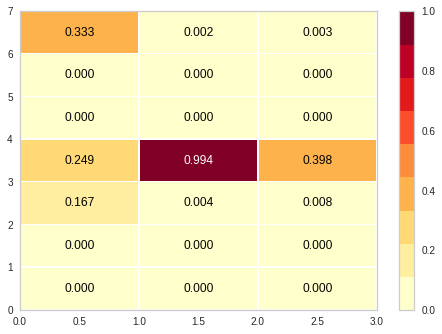

In [51]:
from yellowbrick.classifier import ClassificationReport
import matplotlib.pyplot as plt

visualizer = ClassificationReport(logistic_model,classes=class_names,force_model=True)
visualizer.score(X_features_test, y_test)  
plt.show()